<a href="https://colab.research.google.com/github/rheopy/rheofit/blob/master/notebooks/composite_models/HS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from IPython.display import Math

import rheofit
import pybroom as pb
import corner

import seaborn as sns

In [17]:
!pip install git+https://github.com/rheopy/rheofit.git

  Cloning https://github.com/rheopy/rheofit.git to /tmp/pip-req-build-u19x4opz
  Running command git clone -q https://github.com/rheopy/rheofit.git /tmp/pip-req-build-u19x4opz
  Created wheel for rheofit: filename=rheofit-0.1.0-cp36-none-any.whl size=9868 sha256=6e03786a516297e5654266ea22fd7284faea58c0bc68979ddd093e7c2ae5e624
  Stored in directory: /tmp/pip-ephem-wheel-cache-51u0y46z/wheels/a4/58/61/22fb357c158d287fa7e6b6a2b1cc7379d68d1d40fdbb8daf64
Successfully built rheofit


In [7]:
!git clone https://github.com/rheopy/rheofit.git

Cloning into 'rheofit'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 414 (delta 96), reused 31 (delta 14), pack-reused 228
Receiving objects: 100% (414/414), 2.52 MiB | 2.25 MiB/s, done.
Resolving deltas: 100% (231/231), done.


rheofit  sample_data


In [9]:
#importing data from trios exported excel file
#importing 3rd step in the procedure

data_folder='./rheofit/notebooks/data/'

data_file_list=['HS60_10las_full_15.xls',
                'HS60_10las_full_20.xls',
                'HS60_10las_full_30.xls',
                'HS60_10las_full_40.xls',
                'HS60_10las_full_50.xls']


data_dict={}
for filename in data_file_list:
    data_dict[filename]=pd.read_excel(f'{data_folder}/{filename}',sheet_name=3,skiprows=[0,2])

In [10]:
TCn=rheofit.models.TCn_model
TCn.set_param_hint('TCn_eta_bg', value=0, vary=False)
TCn.set_param_hint('TCn_n', value=0.5, vary=False)

carreau=rheofit.models.carreau_model
carreau.set_param_hint('carreau_n',value=0, vary=False)
model=TCn+carreau

In [11]:
par_wid=rheofit.visualization.make_par_widget(model,data_dict[data_file_list[0]])

In [12]:
params=rheofit.visualization.make_par_from_widget(par_wid)

params.add('carreau_stress_plateau', value=250, min=0, vary=False)
params.add('carreau_eta_0', expr='carreau_stress_plateau/carreau_gammadot_crit')
params

name,value,initial value,min,max,vary,expression
TCn_ystress,1.5335e-04,0.0001533462377310002,0.00000000,inf,True,
TCn_eta_bg,0.00000000,0.0,0.00000000,inf,False,
TCn_gammadot_crit,1.3056e-08,1.3056278502787677e-08,0.00000000,inf,True,
TCn_n,0.50000000,0.5,0.00000000,1.00000000,False,
carreau_eta_0,7.76961845,None,-inf,inf,False,carreau_stress_plateau/carreau_gammadot_crit
carreau_gammadot_crit,32.1766122,32.176612205970976,0.00000000,inf,True,
carreau_n,0.00000000,0.0,0.00000000,1.00000000,False,
carreau_stress_plateau,250.000000,250,0.00000000,inf,False,


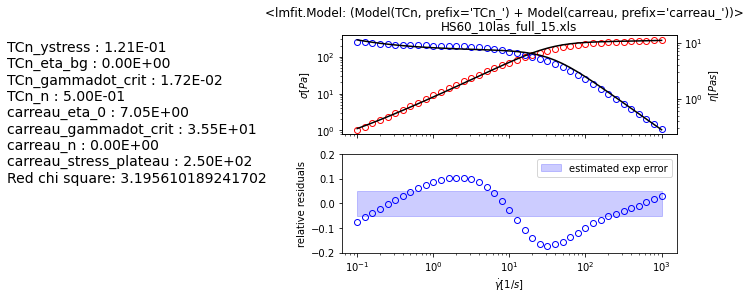

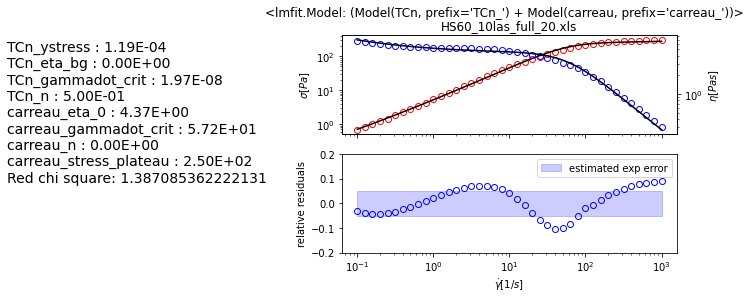

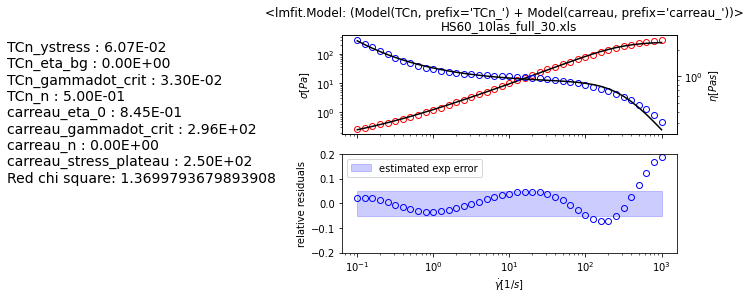

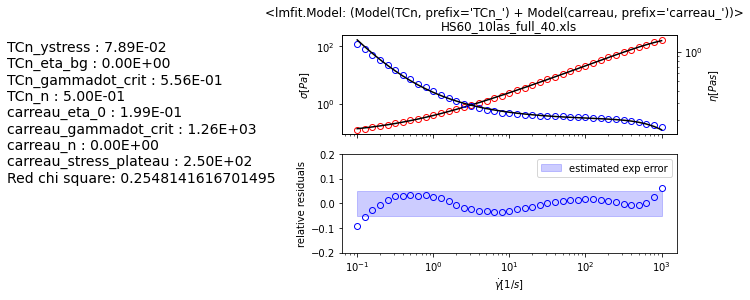

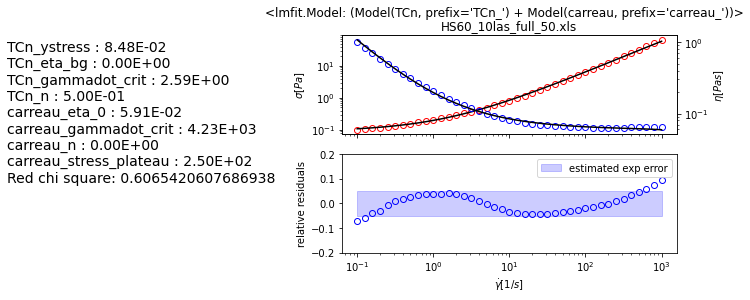

In [13]:
fit_res_dict={}

min_shear_rate=0.1
max_shear_rate=10000

for filename, data in data_dict.items():
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)    
    fit_res=model.fit(data['Stress'],x=data['Shear rate'],params=params,
                                     weights=1/(0.05*data[mask]['Stress']),
                                     nan_policy='omit')
    fit_res_dict[filename]=fit_res
    rheofit.visualization.update_par_widget(par_wid,fit_res)
    
for filename,fit_res in fit_res_dict.items():
    rheofit.visualization.plot_fit_res(fit_res, show_par_values=True);
    plt.title(filename)

In [14]:
table_result=pb.tidy(fit_res_dict)
table_result.pivot(index='key', columns='name', values='value')

name,TCn_eta_bg,TCn_gammadot_crit,TCn_n,TCn_ystress,carreau_eta_0,carreau_gammadot_crit,carreau_n,carreau_stress_plateau
key,,,,,,,,
HS60_10las_full_15.xls,0.0,1.723679e-02,0.5,0.120564,7.050077,35.460606,0.0,250.0
HS60_10las_full_20.xls,0.0,1.967965e-08,0.5,0.000119,4.370897,57.196500,0.0,250.0
HS60_10las_full_30.xls,0.0,3.299962e-02,0.5,0.060742,0.844743,295.948007,0.0,250.0
HS60_10las_full_40.xls,0.0,5.564666e-01,0.5,0.078918,0.199014,1256.190045,0.0,250.0
HS60_10las_full_50.xls,0.0,2.586606e+00,0.5,0.084756,0.059068,4232.442895,0.0,250.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set(**kwargs)


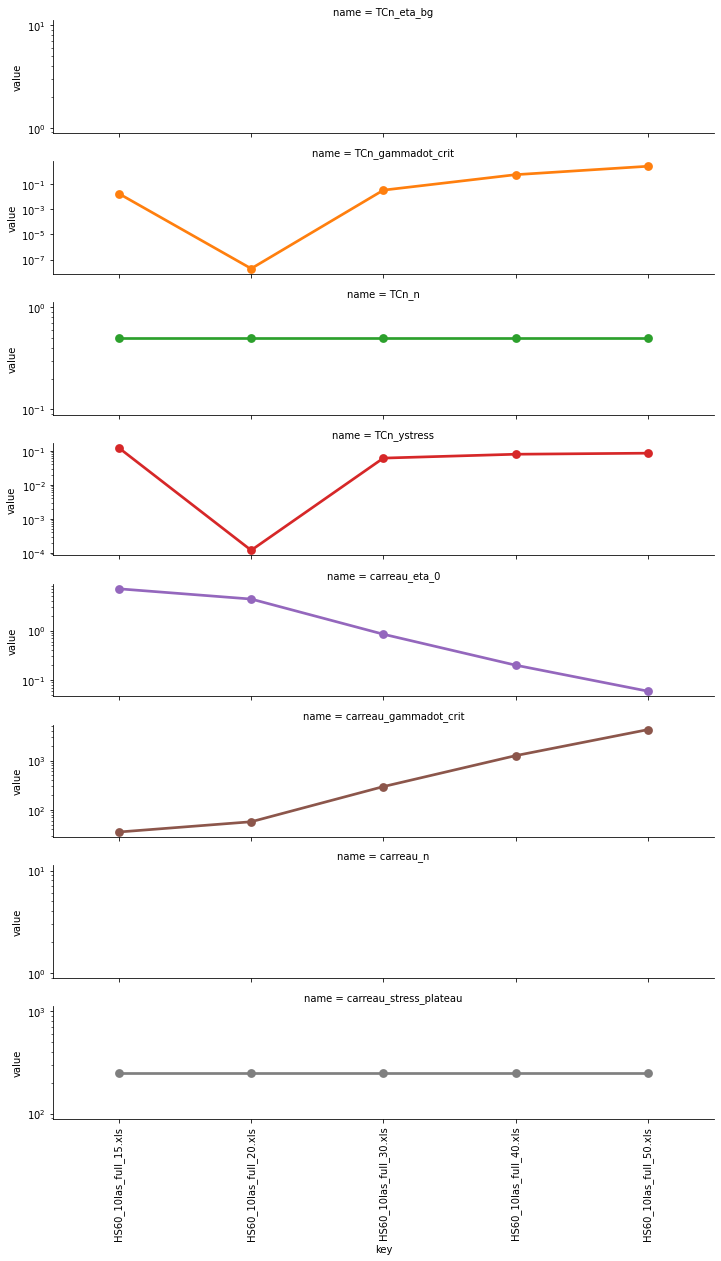

In [15]:
g = sns.catplot(x="key", y="value",
                hue="name", row="name",
                data=pb.tidy(fit_res_dict), kind="point",
                dodge=False,
                sharey=False,
                height=2, aspect=5).set_xticklabels(rotation=90).set(yscale="log")

/usr/local/lib/python3.6/dist-packages/lmfit/model.py:1499: RuntimeWarning: invalid value encountered in add
  df2 += fjac[i]*fjac[j]*covar[i, j]
/usr/local/lib/python3.6/dist-packages/lmfit/model.py:1499: RuntimeWarning: invalid value encountered in add
  df2 += fjac[i]*fjac[j]*covar[i, j]


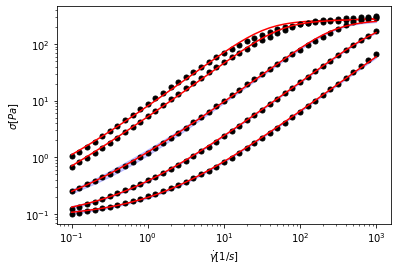

In [16]:
for filename, fit_res in fit_res_dict.items():
    rheofit.visualization.plot_confidence(fit_res,expand=1)